<a href="https://colab.research.google.com/github/sruthiscodes/capstone/blob/main/capstone_stcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Feature extraction and preprocessing

In [1]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.2 MB/s eta 0:00:00


In [2]:
!pip install pywavelets
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
import pywt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

In [56]:
np.random.seed(42)
subjects = range(1,10)
runs = [4, 8, 12]

#preprocessing parameters
samplingFreq = 160
lowFreq = 0.5
highFreq = 45
notchFreq = 60
tMin, tMax = 0, 4

In [57]:
def loadEEG(subject, runs):
  filePaths = eegbci.load_data(subject, runs)
  print(f"Loading data for subject {subject}")
  rawlist = []

  for file in filePaths:
    raw = read_raw_edf(file, preload=True)
    rawlist.append(raw)

  if len(rawlist) > 1:
    raw = mne.concatenate_raws(rawlist)
  else:
    raw = rawlist[0]

  rename_dict = {
        'Fc5.': 'FC5', 'Fc3.': 'FC3', 'Fc1.': 'FC1', 'Fcz.': 'FCz', 'Fc2.': 'FC2', 'Fc4.': 'FC4', 'Fc6.': 'FC6',
        'C5..': 'C5', 'C3..': 'C3', 'C1..': 'C1', 'Cz..': 'Cz', 'C2..': 'C2', 'C4..': 'C4', 'C6..': 'C6',
        'Cp5.': 'CP5', 'Cp3.': 'CP3', 'Cp1.': 'CP1', 'Cpz.': 'CPz', 'Cp2.': 'CP2', 'Cp4.': 'CP4', 'Cp6.': 'CP6',
        'Fp1.': 'Fp1', 'Fpz.': 'Fpz', 'Fp2.': 'Fp2', 'Af7.': 'AF7', 'Af3.': 'AF3', 'Afz.': 'AFz', 'Af4.': 'AF4', 'Af8.': 'AF8',
        'F7..': 'F7', 'F5..': 'F5', 'F3..': 'F3', 'F1..': 'F1', 'Fz..': 'Fz', 'F2..': 'F2', 'F4..': 'F4', 'F6..': 'F6', 'F8..': 'F8',
        'Ft7.': 'FT7', 'Ft8.': 'FT8', 'T7..': 'T7', 'T8..': 'T8', 'T9..': 'T9', 'T10.': 'T10', 'Tp7.': 'TP7', 'Tp8.': 'TP8',
        'P7..': 'P7', 'P5..': 'P5', 'P3..': 'P3', 'P1..': 'P1', 'Pz..': 'Pz', 'P2..': 'P2', 'P4..': 'P4', 'P6..': 'P6', 'P8..': 'P8',
        'Po7.': 'PO7', 'Po3.': 'PO3', 'Poz.': 'POz', 'Po4.': 'PO4', 'Po8.': 'PO8', 'O1..': 'O1', 'Oz..': 'Oz', 'O2..': 'O2', 'Iz..': 'Iz'
    }
  raw.rename_channels(rename_dict)

  montage = mne.channels.make_standard_montage('standard_1020')
  raw.set_montage(montage)

  events, eventID = mne.events_from_annotations(raw)
  raw.filter(l_freq = lowFreq, h_freq = highFreq)
  raw.notch_filter(freqs = notchFreq)

  eventID = dict(T1 = 1, T2 = 2)
  epochs = mne.Epochs(raw, events, eventID, tmin=tMin, tmax=tMax, baseline=None, preload=True)
  return raw, epochs, events, eventID

In [58]:
def cwt(signal, scales, wavelet='morl'):
    coeffs, freqs = pywt.cwt(signal, scales, wavelet)
    return coeffs

In [59]:
def extractFeatures(epochs, scales):
    X = []
    y = []
    data = epochs.get_data()
    labels = epochs.events[:, -1]

    print("Extracting features")
    for i, epoch in enumerate(data):
        features = []
        for channel in epoch:
            # Apply CWT
            coeffs = cwt(channel, scales)
            # Extract statistics from coefficients
            mean = np.mean(coeffs, axis=1)
            std = np.std(coeffs, axis=1)

            # Concatenate the statistics for this channel
            channelFeatures = np.concatenate([mean, std])
            # Add to the list of features (using list append, not numpy append)
            features.append(channelFeatures)

        # Convert list of channel features to flat array
        features = np.concatenate(features)  # Changed from np.array(features).flatten()

        # Add to our collection
        X.append(features)
        y.append(labels[i])

    X = np.array(X)
    y = np.array(y)

    return {'features': X, 'labels': y}

In [60]:
# Initialize data storage
allFeatures = []
allLabels = []

# Process each subject individually
for subject in subjects:
    try:
        print(f"\n{'='*50}\nProcessing subject {subject}\n{'='*50}")

        # Load EEG data for current subject
        raw, epochs, events, eventID = loadEEG(subject, runs)

        # Print basic information about the loaded data
        print(f"Subject {subject} data loaded successfully")
        print(f"Number of channels: {len(raw.ch_names)}")
        print(f"Number of epochs: {len(epochs)}")
        print(f"Sampling frequency: {raw.info['sfreq']} Hz")
        print(f"Duration: {raw.times.max()} seconds")

        # Define wavelet scales
        scales = np.arange(1, 128)

        # Extract features for the current subject
        features = extractFeatures(epochs, scales)
        allFeatures.append(features['features'])
        allLabels.append(features['labels'])

        print(f"Features extracted for subject {subject}")
        print(f"Feature shape: {features['features'].shape}")
        print(f"Labels: {np.unique(features['labels'], return_counts=True)}")

    except Exception as e:
        print(f"Error processing subject {subject}: {e}")
        continue


Processing subject 1
Loading data for subject 1
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a on

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped
Subject 1 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 374.99375 seconds
Extracting features
Features extracted for subject 1
Feature shape: (68, 16256)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 2
Loading data for subject 2
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extrac

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped
Subject 2 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Extracting features


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Features extracted for subject 2
Feature shape: (68, 16256)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 3
Loading data for subject 3
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Set

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped
Subject 3 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 374.99375 seconds
Extracting features
Features extracted for subject 3
Feature shape: (68, 16256)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 4
Loading data for subject 4
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extrac

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped
Subject 4 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Extracting features
Features extracted for subject 4
Feature shape: (68, 16256)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 5


Download complete in 20s (7.3 MB)
Loading data for subject 5
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
De

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
66 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 66 events and 641 original time points ...
0 bad epochs dropped
Subject 5 data loaded successfully
Number of channels: 64
Number of epochs: 66
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Extracting features


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Features extracted for subject 5
Feature shape: (66, 16256)
Labels: (array([1, 2]), array([45, 21]))

Processing subject 6


Download complete in 19s (7.3 MB)
Loading data for subject 6
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
De

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 69 events and 641 original time points ...
0 bad epochs dropped
Subject 6 data loaded successfully
Number of channels: 64
Number of epochs: 69
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Extracting features
Features extracted for subject 6
Feature shape: (69, 16256)
Labels: (array([1, 2]), array([45, 24]))

Processing subject 7


Download complete in 20s (7.4 MB)
Loading data for subject 7
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
De

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 641 original time points ...
0 bad epochs dropped
Subject 7 data loaded successfully
Number of channels: 64
Number of epochs: 68
Sampling frequency: 160.0 Hz
Duration: 374.99375 seconds
Extracting features
Features extracted for subject 7
Feature shape: (68, 16256)
Labels: (array([1, 2]), array([45, 23]))

Processing subject 8


Download complete in 19s (7.3 MB)
Loading data for subject 8
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
De

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FI

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Not setting metadata
67 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 67 events and 641 original time points ...
0 bad epochs dropped
Subject 8 data loaded successfully
Number of channels: 64
Number of epochs: 67
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Extracting features


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Features extracted for subject 8
Feature shape: (67, 16256)
Labels: (array([1, 2]), array([45, 22]))

Processing subject 9


Download complete in 20s (7.3 MB)
Loading data for subject 9
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
De

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 3 contiguous segments
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 s)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 69 events and 641 original time points ...
0 bad epochs dropped
Subject 9 data loaded successfully
Number of channels: 64
Number of epochs: 69
Sampling frequency: 160.0 Hz
Duration: 368.99375 seconds
Extracting features
Features extracted for subject 9
Feature shape: (69, 16256)
Labels: (array([1, 2]), array([45, 24]))


Saved features to ./eeg_data/X_cwt.npy
Saved labels to ./eeg_data/y_cwt.npy

Processing complete!
Features shape: (611, 16256)
Labels shape: (611,)
Unique labels: [1 2]
Label counts: [405 206]
Saved class distribution plot to ./eeg_data/class_distribution.png


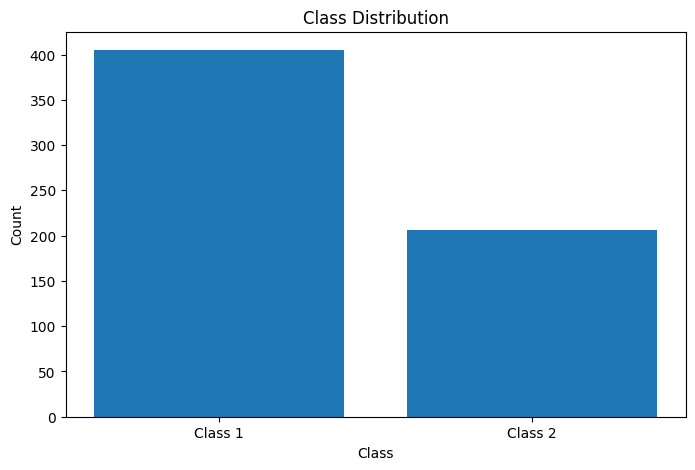

In [61]:
if not os.path.exists('./eeg_data'):
    os.makedirs('./eeg_data')
    print("Created directory: ./eeg_data")

X = np.vstack(allFeatures) if allFeatures else np.array([])
y = np.concatenate(allLabels) if allLabels else np.array([])

if X.size > 0 and y.size > 0:
    np.save('./eeg_data/X_cwt.npy', X)
    np.save('./eeg_data/y_cwt.npy', y)
    print(f"Saved features to ./eeg_data/X_cwt.npy")
    print(f"Saved labels to ./eeg_data/y_cwt.npy")
else:
    print("No features or labels to save. Check if feature extraction was successful.")

print("\nProcessing complete!")
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

if y.size > 0:
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"Unique labels: {unique_labels}")
    print(f"Label counts: {counts}")

    plt.figure(figsize=(8, 5))
    plt.bar(['Class ' + str(c) for c in unique_labels], counts)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.savefig('./eeg_data/class_distribution.png')
    print("Saved class distribution plot to ./eeg_data/class_distribution.png")
    plt.show()

In [62]:
import math
num_samples, total_features = X.shape
possible_channels = [32, 64, 128]  # Common EEG setups

for ch in possible_channels:
    if total_features % ch == 0:
        print(f"Possible shape: ({num_samples}, {ch}, {total_features // ch}, 1)")


Possible shape: (611, 32, 508, 1)
Possible shape: (611, 64, 254, 1)
Possible shape: (611, 128, 127, 1)


Unique labels after resampling: [1 2]
Label counts after resampling: [405 405]


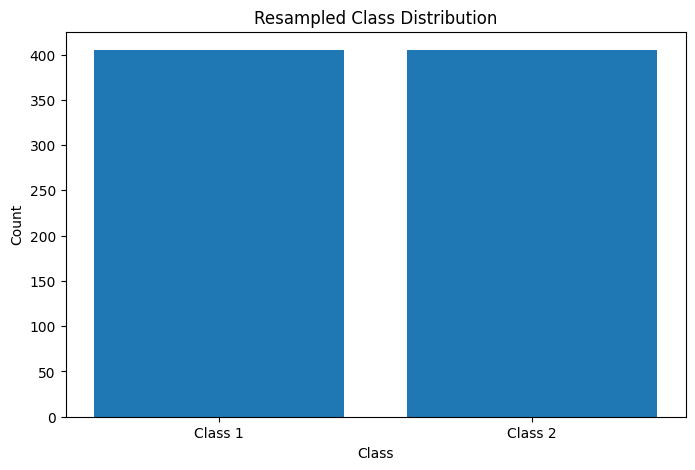

In [64]:
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# Apply SMOTE to balance classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class distribution after SMOTE
unique_labels_resampled, counts_resampled = np.unique(y_resampled, return_counts=True)
print(f"Unique labels after resampling: {unique_labels_resampled}")
print(f"Label counts after resampling: {counts_resampled}")

# Save the resampled data
np.save('./eeg_data/X_resampled.npy', X_resampled)
np.save('./eeg_data/y_resampled.npy', y_resampled)

# Plot resampled class distribution
plt.figure(figsize=(8, 5))
plt.bar(['Class ' + str(c) for c in unique_labels_resampled], counts_resampled)
plt.title('Resampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('./eeg_data/resampled_class_distribution.png')
plt.show()


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Load extracted features
X_cwt = np.load('./eeg_data/X_cwt.npy')

# Select a sample for visualization
sample_index = 0  # Change index to visualize different samples
sample_cwt = X_cwt[sample_index]

# Plot Scalogram (Time-Frequency Representation)
plt.figure(figsize=(10, 5))
plt.imshow(np.abs(sample_cwt), aspect='auto', cmap='jet')
plt.colorbar(label='Magnitude')
plt.xlabel('Time')
plt.ylabel('Scales')
plt.title(f'Scalogram for Sample {sample_index}')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: './eeg_data/X_cwt.npy'

stcnn diff approach


In [68]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

# Reshape input data for STCNN (samples, channels, time_steps, 1, 1)
num_samples = X.shape[0]
num_channels = 64
time_steps = 254
X_reshaped = X.reshape(num_samples, num_channels, time_steps, 1, 1)

# Standardize each channel independently
for i in range(X_reshaped.shape[1]):
    X_reshaped[:, i, :, 0, 0] = StandardScaler().fit_transform(X_reshaped[:, i, :, 0, 0])

# Convert labels to categorical (One-Hot Encoding)
y_categorical = to_categorical(y)

# Build STCNN Model
model = Sequential([
    Conv3D(32, (3, 3, 1), activation='relu', input_shape=(num_channels, time_steps, 1, 1)),
    BatchNormalization(),
    MaxPooling3D((2, 2, 1)),

    Conv3D(64, (3, 3, 1), activation='relu'),
    BatchNormalization(),
    MaxPooling3D((2, 2, 1)),

    Conv3D(128, (3, 3, 1), activation='relu'),
    BatchNormalization(),
    MaxPooling3D((2, 2, 1)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_reshaped, y_categorical, epochs=20, batch_size=16, validation_split=0.3)

# Evaluate
test_loss, test_acc = model.evaluate(X_reshaped, y_categorical)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5701 - loss: 6.8266 - val_accuracy: 0.5489 - val_loss: 2.4107
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6756 - loss: 5.9063 - val_accuracy: 0.4511 - val_loss: 5.9717
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6591 - loss: 3.4992 - val_accuracy: 0.6793 - val_loss: 1.3161
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.7330 - loss: 1.8380 - val_accuracy: 0.5761 - val_loss: 1.2334
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7526 - loss: 0.8707 - val_accuracy: 0.6359 - val_loss: 1.5475
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7774 - loss: 0.6963 - val_accuracy: 0.6141 - val_loss: 1.1159
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7815 - loss: 0.5984 - val_accuracy: 0.6250 - val_loss: 1.3876
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8270 - loss: 0.4949 - val_accuracy: 0.6630 - val_loss:

In [66]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load resampled data
X_resampled = np.load('./eeg_data/X_resampled.npy')
y_resampled = np.load('./eeg_data/y_resampled.npy')

# Reshape X_resampled to (samples, channels, time, 1)


# Convert labels to categorical
num_classes = len(np.unique(y_resampled))
y_resampled -= 1  # Convert labels from [1, 2] to [0, 1]
num_classes = len(np.unique(y_resampled))  # Recalculate
y_resampled = to_categorical(y_resampled, num_classes)



print("Final X shape:", X_resampled.shape)
print("Final y shape:", y_resampled.shape)


Final X shape: (810, 16256)
Final y shape: (810, 2)


# stcnn-notpretrained

In [25]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load resampled data
X_resampled = np.load('./eeg_data/X_resampled.npy')
y_resampled = np.load('./eeg_data/y_resampled.npy')

# Reshape X_resampled to (samples, channels, time, 1)
X_resampled = X_resampled.reshape(360, 64, 254, 1)

# Convert labels to categorical
num_classes = len(np.unique(y_resampled))
y_resampled -= 1  # Convert labels from [1, 2] to [0, 1]
num_classes = len(np.unique(y_resampled))  # Recalculate
y_resampled = to_categorical(y_resampled, num_classes)



print("Final X shape:", X_resampled.shape)
print("Final y shape:", y_resampled.shape)


Final X shape: (360, 64, 254, 1)
Final y shape: (360, 2)


In [26]:
X_resampled = X_resampled.reshape(360, 64, 254, 1)  # (samples, channels, time, 1)
print("Reshaped X_resampled shape:", X_resampled.shape)


Reshaped X_resampled shape: (360, 64, 254, 1)


In [27]:
print("Unique labels in y_resampled:", np.unique(y_resampled))
print("num_classes:", num_classes)


Unique labels in y_resampled: [0. 1.]
num_classes: 2


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")


Train shape: (288, 64, 254, 1), (288, 2)
Test shape: (72, 64, 254, 1), (72, 2)


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Flatten, Dense, Dropout, MaxPooling2D

# STCNN Model
model = Sequential([
    Conv2D(16, (3, 3), padding="same", input_shape=(64, 254, 1)),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 254, 16)         │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 254, 16)         │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 254, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 127, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 127, 32)         │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 127, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 127, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 31, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15872)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,031,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,055,746 (7.84 MB)

 Trainable params: 2,055,522 (7.84 MB)

 Non-trainable params: 224 (896.00 B)

In [30]:
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 596ms/step - accuracy: 0.5156 - loss: 0.8414 - val_accuracy: 0.6379 - val_loss: 0.6931
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 556ms/step - accuracy: 0.6119 - loss: 0.6822 - val_accuracy: 0.6379 - val_loss: 0.6931
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 707ms/step - accuracy: 0.5602 - loss: 0.6757 - val_accuracy: 0.3621 - val_loss: 0.6937
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 528ms/step - accuracy: 0.6324 - loss: 0.6380 - val_accuracy: 0.6379 - val_loss: 0.6926
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 507ms/step - accuracy: 0.6904 - loss: 0.5915 - val_accuracy: 0.6379 - val_loss: 0.6896
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 569ms/step - accuracy: 0.7109 - loss: 0.5631 - val_accuracy: 0.6379 - val_loss: 0.6871
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 530ms/step - accuracy: 0.6806 - loss: 0.5977 - val_accuracy: 0.6379 - val_loss: 0.6898
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7392 - loss: 0.5255 - val_accuracy: 0.6379 - val_loss: 0

In [31]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.4805 - loss: 0.6980
Test Accuracy: 50.00%


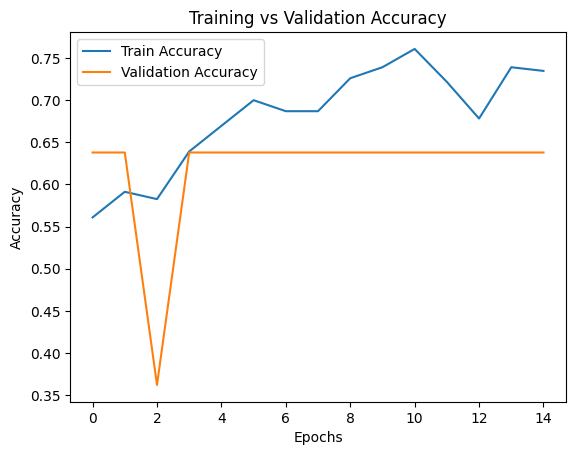

In [34]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


#pretrained models


In [36]:
#EEGnet
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, SeparableConv2D, BatchNormalization, Activation, AveragePooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split

# 🚀 Load Resampled EEG Data
X_resampled = np.load('./eeg_data/X_resampled.npy')
y_resampled = np.load('./eeg_data/y_resampled.npy')

# 🔹 Reshape EEG Data for EEGNet
X_resampled = X_resampled.reshape(X_resampled.shape[0], 64, 254, 1)  # Shape: (samples, channels, time, 1)

# 🔹 Convert Labels to One-Hot Encoding
num_classes = len(np.unique(y_resampled))
y_resampled = to_categorical(y_resampled - 1, num_classes)  # Shift labels to start from 0

# 🔹 Split Data for Training & Testing
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 🔥 Define EEGNet Model
def EEGNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Conv2D Layer
    x = Conv2D(16, (1, 64), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((64, 1), use_bias=False, depth_multiplier=2, depthwise_constraint=tf.keras.constraints.max_norm(1.))(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(0.5)(x)

    # SeparableConv2D Layer
    x = SeparableConv2D(16, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 8))(x)
    x = Dropout(0.5)(x)

    # Fully Connected Layer
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# 🎯 Initialize EEGNet Model
model = EEGNet((64, 254, 1), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 🚀 Train the Model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# 🎯 Evaluate on Test Data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 832ms/step - accuracy: 0.5445 - loss: 0.6948 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 753ms/step - accuracy: 0.6328 - loss: 0.6608 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 761ms/step - accuracy: 0.6857 - loss: 0.6438 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 608ms/step - accuracy: 0.6394 - loss: 0.6674 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 769ms/step - accuracy: 0.7211 - loss: 0.6164 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 770ms/step - accuracy: 0.6654 - loss: 0.6419 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 598ms/step - accuracy: 0.6854 - loss: 0.6369 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 764ms/step - accuracy: 0.6474 - loss: 0.6410 - val_accuracy: 0.5000 - val_lo

In [55]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# 📌 Load Resampled Data
X_resampled = np.load('./eeg_data/X_resampled.npy')
y_resampled = np.load('./eeg_data/y_resampled.npy')

# Ensure X_resampled is a NumPy array
X_resampled = np.array(X_resampled)
y_resampled = np.array(y_resampled)

print("Original X shape:", X_resampled.shape)  # (360, 16256)

# 📌 Reshape EEG Data for ResNet50
X_resampled = X_resampled.reshape(-1, 64, 254, 1)  # (360, 64, 254, 1)

# Convert to 3-channel images by repeating along the last axis
X_resampled = np.repeat(X_resampled, 3, axis=-1)  # (360, 64, 254, 3)

# Resize to match ResNet50 input (224x224)
X_resampled = tf.image.resize(X_resampled, (224, 224)).numpy()  # Convert back to NumPy

print("Final X shape:", X_resampled.shape)

# 📌 One-Hot Encode Labels
num_classes = len(np.unique(y_resampled))  # Get number of unique classes
y_resampled = to_categorical(y_resampled - 1, num_classes)  # Shift labels to start from 0

print("Final y shape:", y_resampled.shape)

# ✅ Convert indices to int before train-test split
y_resampled = np.asarray(y_resampled, dtype=np.int32)

# 📌 Split into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 📌 Load Pretrained ResNet50 (without the top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 📌 Freeze base model layers
base_model.trainable = False

# 📌 Add Custom Layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)  # Output layer

# 📌 Build Final Model
model = Model(inputs=base_model.input, outputs=output)

# 📌 Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 📌 Train Model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split=0.2)

# 📌 Evaluate on Test Data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")


Original X shape: (360, 16256)
Final X shape: (360, 224, 224, 3)
Final y shape: (360, 2)
Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - accuracy: 0.5111 - loss: 0.8128 - val_accuracy: 0.5000 - val_loss: 0.7158
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - accuracy: 0.5140 - loss: 0.7089 - val_accuracy: 0.5000 - val_loss: 0.7029
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.5251 - loss: 0.7464 - val_accuracy: 0.5000 - val_loss: 0.7496
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.5020 - loss: 0.7247 - val_accuracy: 0.5000 - val_loss: 0.6981
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.4915 - loss: 0.6969 - val_accuracy: 0.5000 - val_loss: 0.7040
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - accuracy: 0.4924 - loss: 0.7094 - val_accuracy: 0.5000 - val_loss: 0.7058
Epoch 7/15
3/8 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.5938 - loss: 0.6804

KeyboardInterrupt: 